In [1]:
!pip install --upgrade -q amazon-textract-textractor[pdf] 

In [2]:
import os
from PIL import Image
from textractor import Textractor
from textractor.visualizers.entitylist import EntityList
from textractor.data.constants import TextractFeatures, Direction, DirectionalFinderType

In [3]:
extractor = Textractor(profile_name="default")

document = extractor.analyze_document(
    file_source='./income_statement.png',
    features=[TextractFeatures.TABLES], 
    save_image=True
)

In [4]:
document

This document holds the following data:
Pages - 1
Words - 141
Lines - 58
Key-values - 0
Checkboxes - 0
Tables - 1
Queries - 0
Signatures - 0
Identity Documents - 0
Expense Documents - 0

In [5]:
document.text

'MANAGEMENT\nDISCUSSION AND ANALYSIS\nYear Ended December 31, 2022 Compared to Year Ended December 31, 2021\nThe following table sets forth the comparative figures for the years ended December 31, 2022 and 2021:\n\n\n \t Year ended\t December 31,\n \t 2022 (RMB in\t 2021 millions)\n Revenue\t 280,044.0\t 328,309.1\n Cost of sales\t (232,466.8)\t (270,048.2)\n Gross profit\t 47,577.2\t 58,260.9\n Research and development expenses\t (16,028.1)\t (13,167.1)\n Selling and marketing expenses\t (21,323.3)\t (20,980.8)\n Administrative expenses\t (5,113.9)\t (4,738.9)\n Fair value changes on investments measured at fair value through profit or loss\t (1,662.0)\t 8,132.1\n Share of net (losses)/profits of investments accounted for using the equity method\t (400.1)\t 275.0\n Other income\t 1,135.5\t 826.9\n Other losses, net\t (1,368.8)\t (2,579.5)\n Operating profit\t 2,816.5\t 26,028.6\n Finance income/(costs), net\t 1,117.5\t (1,611.6)\n Profit before income tax\t 3,934.0\t 24,417.0\n Income

ValueError: Could not save to JPEG for display

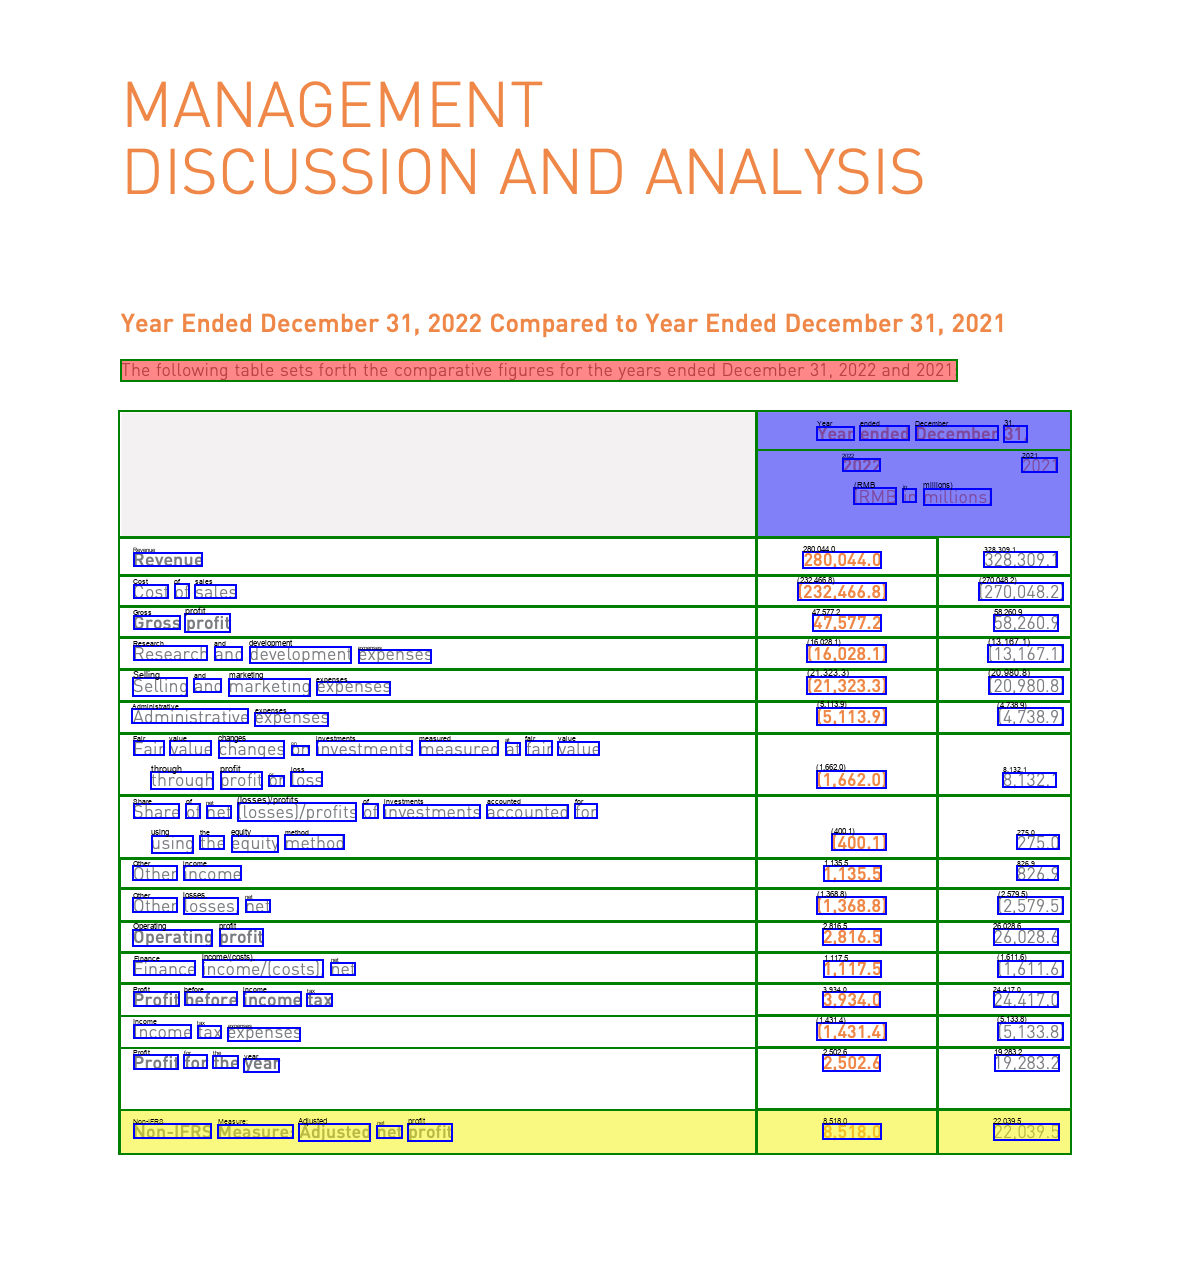

In [6]:
table = EntityList(document.tables[0])
document.tables[0].visualize()

In [7]:
table[0].to_pandas()

,0,1,2
0,,Year ended,"December 31,"
1,,2022 (RMB in,2021 millions)
2,Revenue,"280,044.0","328,309.1"
3,Cost of sales,"(232,466.8)","(270,048.2)"
4,Gross profit,"47,577.2","58,260.9"
5,Research and development expenses,"(16,028.1)","(13,167.1)"
6,Selling and marketing expenses,"(21,323.3)","(20,980.8)"
7,Administrative expenses,"(5,113.9)","(4,738.9)"
8,Fair value changes on investments measured at ...,"(1,662.0)","8,132.1"
9,Share of net (losses)/profits of investments a...,(400.1),275.0


In [8]:
dftable = table[0].to_pandas()
# Write the DataFrame to a CSV file
dftable.to_csv('table.csv', index=False)

In [9]:
def processing_csv_to_string(dataframe):
    column_names = dataframe.columns.tolist()

    table_as_string = ""
    for index_c in range(len(column_names)):
        table_as_string += '"' + str(column_names[index_c]) + '"' + ','
        #table_as_string += '\t'
    table_as_string += '\n'

    # Loop over DataFrame using iloc
    for index_r in range(len(dataframe)):
        row = dataframe.iloc[index_r]
        for index_c in range(len(row)):
            table_as_string += '"' + str(row.iloc[index_c]) + '"' + ','
            #table_as_string += '\t'
        table_as_string += '\n'
    return table_as_string


In [10]:
print(processing_csv_to_string(dftable))

"0","1","2",
"","Year ended","December 31,",
"","2022 (RMB in","2021 millions)",
"Revenue","280,044.0","328,309.1",
"Cost of sales","(232,466.8)","(270,048.2)",
"Gross profit","47,577.2","58,260.9",
"Research and development expenses","(16,028.1)","(13,167.1)",
"Selling and marketing expenses","(21,323.3)","(20,980.8)",
"Administrative expenses","(5,113.9)","(4,738.9)",
"Fair value changes on investments measured at fair value through profit or loss","(1,662.0)","8,132.1",
"Share of net (losses)/profits of investments accounted for using the equity method","(400.1)","275.0",
"Other income","1,135.5","826.9",
"Other losses, net","(1,368.8)","(2,579.5)",
"Operating profit","2,816.5","26,028.6",
"Finance income/(costs), net","1,117.5","(1,611.6)",
"Profit before income tax","3,934.0","24,417.0",
"Income tax expenses","(1,431.4)","(5,133.8)",
"Profit for the year","2,502.6","19,283.2",
"Non-IFRS Measure: Adjusted net profit","8,518.0","22,039.5",



In [11]:
!pip install -q langchain==0.0.320

In [12]:
import langchain
print(langchain.__version__)
from langchain.llms.bedrock import Bedrock
import boto3
print(boto3.__version__)

0.0.320
1.28.80


In [13]:
from langchain.llms import Bedrock

BEDROCK_CLIENT = boto3.client('bedrock-runtime', 'us-east-1')
llm = Bedrock(model_id="anthropic.claude-v2",client=BEDROCK_CLIENT)

TABLE_NAME = "table.csv"

In [14]:
from langchain import PromptTemplate

# Create a prompt template that has multiple input variables
prompt_template = """

Human: Use the following pieces of table to provide a concise answer to the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. Please note that all the key information is between double quote " ", including numbers and row and column names). 
If the value is " " or "-" or "_", it means 0 as value.
In most of the scenerio, you can search the results directly from the table. 

{retrieved_information}


Question: {user_query}, step by step explain how to get the results
Assistant:

"""

prompt = PromptTemplate.from_template(prompt_template)

In [15]:
from langchain.prompts import StringPromptTemplate
import pandas as pd
from sklearn.preprocessing import normalize
import numpy as np 
import pandas as pd
import json 
from io import StringIO


class RetrievedPromptTemplate(StringPromptTemplate):
    embedding_endpoint_name = "jumpstart-dft-meta-textgeneration-llama-2-7b-f"
    table_name = TABLE_NAME

    def format(self, **kwargs) -> str:
        user_query = kwargs.pop("user_query")
        retrieved_information = self.fetch_retrieved_information(self.table_name)

        kwargs["user_query"] = user_query
        kwargs["retrieved_information"] = retrieved_information
        return prompt.format(**kwargs)

    def fetch_retrieved_information(self, table_name):
        df = pd.read_csv(table_name)
        df = self.replace_n(df)
        table_as_string = self.dataframe_to_string_formatted(df)
        return table_as_string

    def replace_n(self,df): 
        # Replace "\n" in cell contents with "_"
        df.replace("\n", " ", regex=True, inplace=True)

        # Replace "/n" in column names with "_"
        df.rename(columns=lambda x: x.replace('\n', ' '), inplace=True)
        return df

    def dataframe_to_string_formatted(self,df):
        column_names = df.columns.tolist()
        #print(len(column_names))

        table_as_string = ""
        for index_c in range(len(column_names)):
            table_as_string += '"' + str(column_names[index_c]) + '"' + ','
            #table_as_string += '\t'
        table_as_string += '\n'

        # Loop over DataFrame using iloc
        for index_r in range(len(df)):
            row = df.iloc[index_r]
            for index_c in range(len(row)):
                table_as_string += '"' + str(row.iloc[index_c]) + '"' + ','
                #table_as_string += '\t'
            table_as_string += '\n'
            
        return table_as_string


In [16]:
prompt_template = RetrievedPromptTemplate(input_variables=["user_query"])


In [17]:
Question = """
What is the Operating profit for the year of 2022?
"""

In [18]:
print(prompt_template.format(user_query=Question))



Human: Use the following pieces of table to provide a concise answer to the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. Please note that all the key information is between double quote " ", including numbers and row and column names). 
If the value is " " or "-" or "_", it means 0 as value.
In most of the scenerio, you can search the results directly from the table. 

"0","1","2",
"nan","Year ended","December 31,",
"nan","2022 (RMB in","2021 millions)",
"Revenue","280,044.0","328,309.1",
"Cost of sales","(232,466.8)","(270,048.2)",
"Gross profit","47,577.2","58,260.9",
"Research and development expenses","(16,028.1)","(13,167.1)",
"Selling and marketing expenses","(21,323.3)","(20,980.8)",
"Administrative expenses","(5,113.9)","(4,738.9)",
"Fair value changes on investments measured at fair value through profit or loss","(1,662.0)","8,132.1",
"Share of net (losses)/profits of investments accounted for using the equ

In [19]:
from langchain.chains import LLMChain

langchain.verbose = True
llmchain = LLMChain(llm=llm, prompt=prompt_template)
rag_results = llmchain.run({
    'user_query': Question,
    })
print(rag_results)



> Entering new LLMChain chain...
Prompt after formatting:


Human: Use the following pieces of table to provide a concise answer to the question at the end. 
If you don't know the answer, just say that you don't know, don't try to make up an answer. Please note that all the key information is between double quote " ", including numbers and row and column names). 
If the value is " " or "-" or "_", it means 0 as value.
In most of the scenerio, you can search the results directly from the table. 

"0","1","2",
"nan","Year ended","December 31,",
"nan","2022 (RMB in","2021 millions)",
"Revenue","280,044.0","328,309.1",
"Cost of sales","(232,466.8)","(270,048.2)",
"Gross profit","47,577.2","58,260.9",
"Research and development expenses","(16,028.1)","(13,167.1)",
"Selling and marketing expenses","(21,323.3)","(20,980.8)",
"Administrative expenses","(5,113.9)","(4,738.9)",
"Fair value changes on investments measured at fair value through profit or loss","(1,662.0)","8,132.1",
"Share of net